In [1]:
!pip install -q --upgrade openai
!pip install -q python-dotenv
!pip install -q geopandas contextily shapely folium

In [2]:
import sys
sys.path.append('/content')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from time import sleep
from googlesearch import search
from openai import OpenAI
from helper_functions import *
import json
import folium
import random


warnings.filterwarnings('ignore')

## **Fetch Treatment & Disposal Facilities from the EPA Website**

#### **Used Classes:** Commercial Autoclaves, Medical/ Biohazardous Waste Incinerators


In [3]:
df = fetch_facilities("4,14")
df = normalize_company_names(df)
df.facilitySubtypeIds = df.facilitySubtypeIds.apply(lambda x: 'Incinerator' if '4' in x else 'Autoclave')
df['name'] = df['name'].str.replace(",", "", regex=False).str.replace(".", "", regex=False).str.replace("Inc", "", regex=False)
df['name'] = df.name.apply(lambda x: x.strip())
company_names = df.name

Total facilities to fetch: 141
Fetched 141 facilities


## **Run AI/Search Tools**

In [44]:
prompts = {
    "status": "Determine if the company named {name} is publicly traded or privately held. Respond with only one word: 'Public' or 'Private'. Avoid providing ANY additional information or context.",
    "private_equity_backer": "Identify the private equity investors, if any, of {name}. If no information is available or the company does not have private equity backers, respond with 'Unknown' without adding ANY additional text.",
    "company_website": "Provide the website URL of the company named {name}. Respond with only the website URL. Do NOT include any additional information or context.",
    "relevance": "Determine if the company named {name} is a relevant player in the medical waste management industry. Respond with only one word: 'Relevant' or 'Not relevant'. Avoid providing ANY additional information or context."
}

### OpenAI

In [45]:
from tqdm import tqdm
import time

company_names = df.name
info_collected = []
company_info_chatGPT = []

for name in tqdm(company_names, desc="Processing companies"):
    info_collected = {
        "company": name,
        "status": "",
        "private_equity_backer": "",
        "company_website": "",
        "relevance": ""
    }
    for key, prompt in prompts.items():
        info_collected[key] = call_openai_api(prompt.format(name=name))
        sleep(0.2)
    company_info_chatGPT.append(info_collected)

Processing companies: 100%|██████████| 141/141 [07:46<00:00,  3.31s/it]


### Gemini

In [46]:
from tqdm import tqdm
import time

company_info_gemini = []

for name in tqdm(company_names, desc="Processing companies"):
    info_collected = {
        "company": name,
        "status": "",
        "private_equity_backer": "",
        "company_website": "",
        "relevance": ""
    }
    for key, prompt in prompts.items():
        info_collected[key] = call_gemini_api(prompt.format(name=name))
        sleep(0.2)
    company_info_gemini.append(info_collected)

Processing companies: 100%|██████████| 141/141 [04:32<00:00,  1.94s/it]


### Perplexity

In [47]:
from tqdm import tqdm
import time

company_info_perplexity = []

for name in tqdm(company_names, desc="Processing companies"):
    info_collected = {
        "company": name,
        "status": "",
        "private_equity_backer": "",
        "company_website": "",
        "relevance": ""
    }
    for key, prompt in prompts.items():
        info_collected[key] = call_perplexity_api(prompt.format(name=name))
        sleep(0.2)
    company_info_perplexity.append(info_collected)

Processing companies: 100%|██████████| 141/141 [13:16<00:00,  5.65s/it]


### Create JSON files for the three models, for persistence

In [48]:
file_names = [("company_info_chatGPT.json", company_info_chatGPT), ("company_info_perplexity.json", company_info_perplexity), ("company_info_gemini.json", company_info_gemini)]

for file_name, company_info in file_names:
  with open(file_name, "w") as file:
    json.dump(company_info, file, indent=4)

### Google Search API
#### *Goal*: To collect number of Google Results per company, in order to further assess relevance

In [4]:
count_75 = []
count_75_to_end = []

for name in company_names[:75]:
  result  = get_google_search_results_count_first(f"{name} medical waste management facility")
  count_75.append(result)

for name in company_names[75:]:
  result  = get_google_search_results_count_second(f"{name} medical waste management facility")
  count_75_to_end.append(result)

count_list = count_75 + count_75_to_end

output_file = "search_results.txt"
with open(output_file, "w") as file:
    for item in count_list:
        file.write(f"{item}\n")

print(f"List saved to {output_file}")

List saved to search_results.txt


## **Data Preparation**

### Convert JSON files to DataFrames

In [4]:
df_chatgpt = json_to_df('company_info_chatGPT.json')
df_gemini = json_to_df('company_info_gemini.json')
df_perplexity = json_to_df('company_info_perplexity.json')

Successfully loaded company_info_chatGPT.json into a DataFrame.
Successfully loaded company_info_gemini.json into a DataFrame.
Successfully loaded company_info_perplexity.json into a DataFrame.


### Gemini

In [5]:
df_gemini = explode_columns_gemini(df_gemini, ["status", "private_equity_backer", "company_website", "relevance"])

cols = ["company_website", "status", "status", "private_equity_backer", "relevance", "relevance"]
values = ["Unknown", "Public", "Private", "Unknown", "Not relevant", "Relevant"]

df_gemini = normalize_columns(df_gemini, cols, values)
df_gemini.company_website = df_gemini.company_website.apply(lambda x: x.replace("\n", ""))

### Perplexity

In [6]:
df_perplexity = explode_columns_perplexity(df_perplexity, ["status", "private_equity_backer", "company_website", "relevance"])

cols = ["company_website", "status", "status", "private_equity_backer", "relevance", "relevance"]
values = ["Unknown", "Public", "Private", "Unknown", "Not relevant", "Relevant"]
df_perplexity = normalize_columns(df_perplexity, cols, values)

### Use Mode for Status and Relevance columns

In [7]:
result_df = get_mode(df_chatgpt, [df_chatgpt, df_gemini, df_perplexity], 'status')
result_df = get_mode(result_df, [df_chatgpt, df_gemini, df_perplexity], 'relevance')

### Add Google Search Count

In [8]:
input_file = "search_results.txt"

with open(input_file, "r") as file:
    count_list = [line.strip() for line in file]

In [9]:
result_df['google_search_count'] = [int(x) for x in count_list]

### Merge EPA data and AI data into one DataFrame

In [10]:
merged_df = df.join(result_df).drop(columns=['company', 'id', 'streetAddress', 'city', 'county', 'epaRegion', 'zipCode', 'sourceId', 'facilitySubtypes'])

In [11]:
columns = list(merged_df.columns)
columns.insert(columns.index('contactPhone') + 1, columns.pop(columns.index('company_website')))
merged_df = merged_df[columns]

### Keep only relevant companies

In [12]:
merged_df = merged_df[merged_df.relevance == 'Relevant'].sort_values(by='google_search_count', ascending=False)

## **Data Exploration**

### Most relevant companies

In [13]:
df_tmp = (
    merged_df[['name', 'google_search_count']]
    .sort_values(by='google_search_count', ascending=False)
    .drop_duplicates(subset='name')
    .head(10)
).reset_index(drop=True)

company_states = {name: [] for name in df_tmp['name']}
company_subtype = {name: [] for name in df_tmp['name']}



for company in df_tmp['name']:
    matching_rows = merged_df[merged_df['name'] == company]
    states = matching_rows['stateCode'].unique()
    company_states[company].extend(states)
    subtypes = matching_rows['facilitySubtypeIds'].unique()
    company_subtype[company].extend(subtypes)

df_tmp['stateCode'] = df_tmp['name'].map(company_states)
df_tmp['facilitySubtypeIds'] = df_tmp['name'].map(company_subtype).apply(lambda x: x[0] if len(x)==1 else x)


df_tmp = df_tmp.drop(columns=['google_search_count'])
top_companies = df_tmp['name'].tolist()

df_tmp_facilities = merged_df[merged_df['name'].isin(top_companies)].sort_values(by=['stateCode', 'google_search_count'], ascending=[True, False])


In [14]:
df_tmp_facilities.to_csv('top_companies_facilities_sorted_by_state.csv', index=False)

### Get Location Images

,Facility Type,Count
0,Incinerator,8
1,Autoclave,51


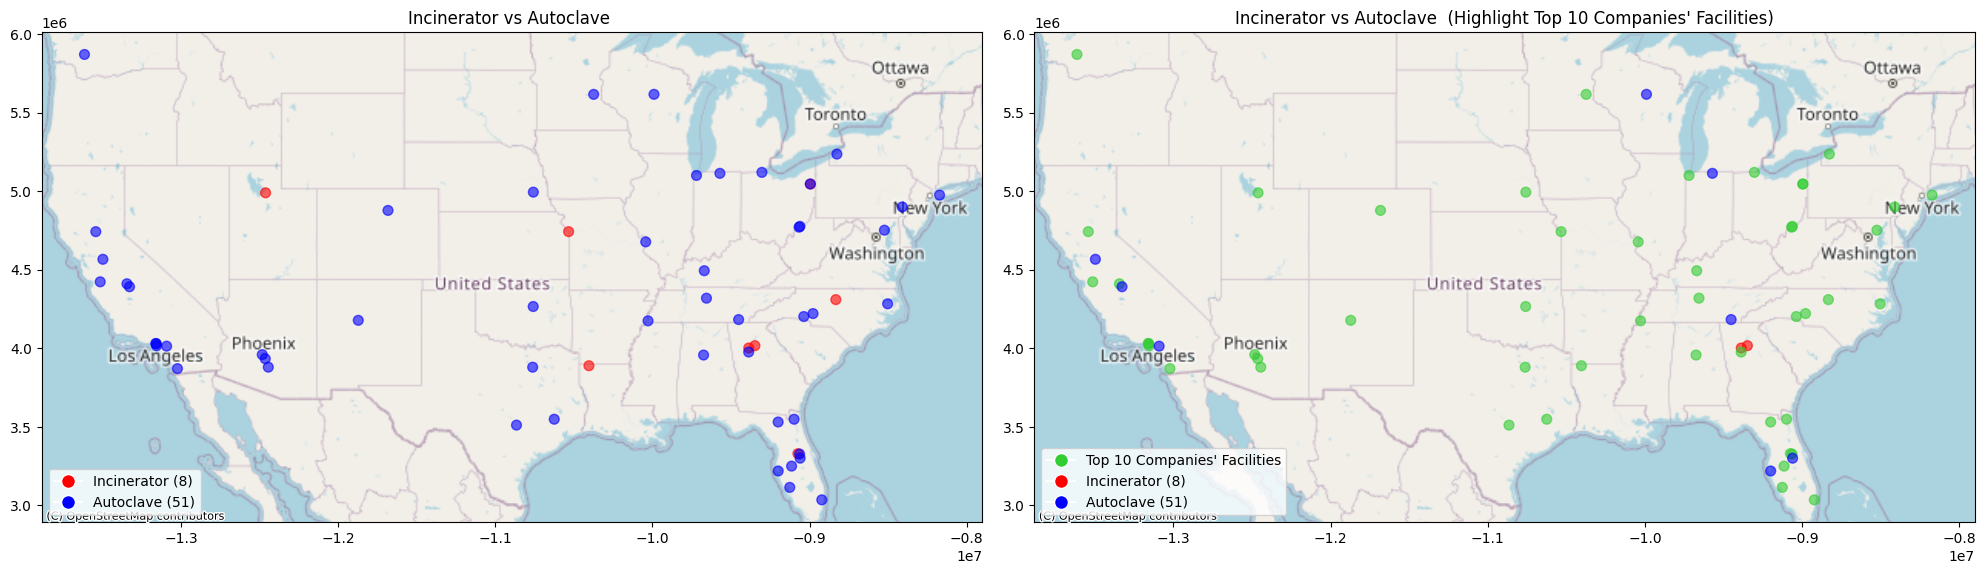

'Incinerator_vs_Autoclave__side_by_side.png'

In [15]:
generate_google_style_static_map(merged_df, top_companies=top_companies)

,Facility Type,Count
0,Private,22
1,Public,37


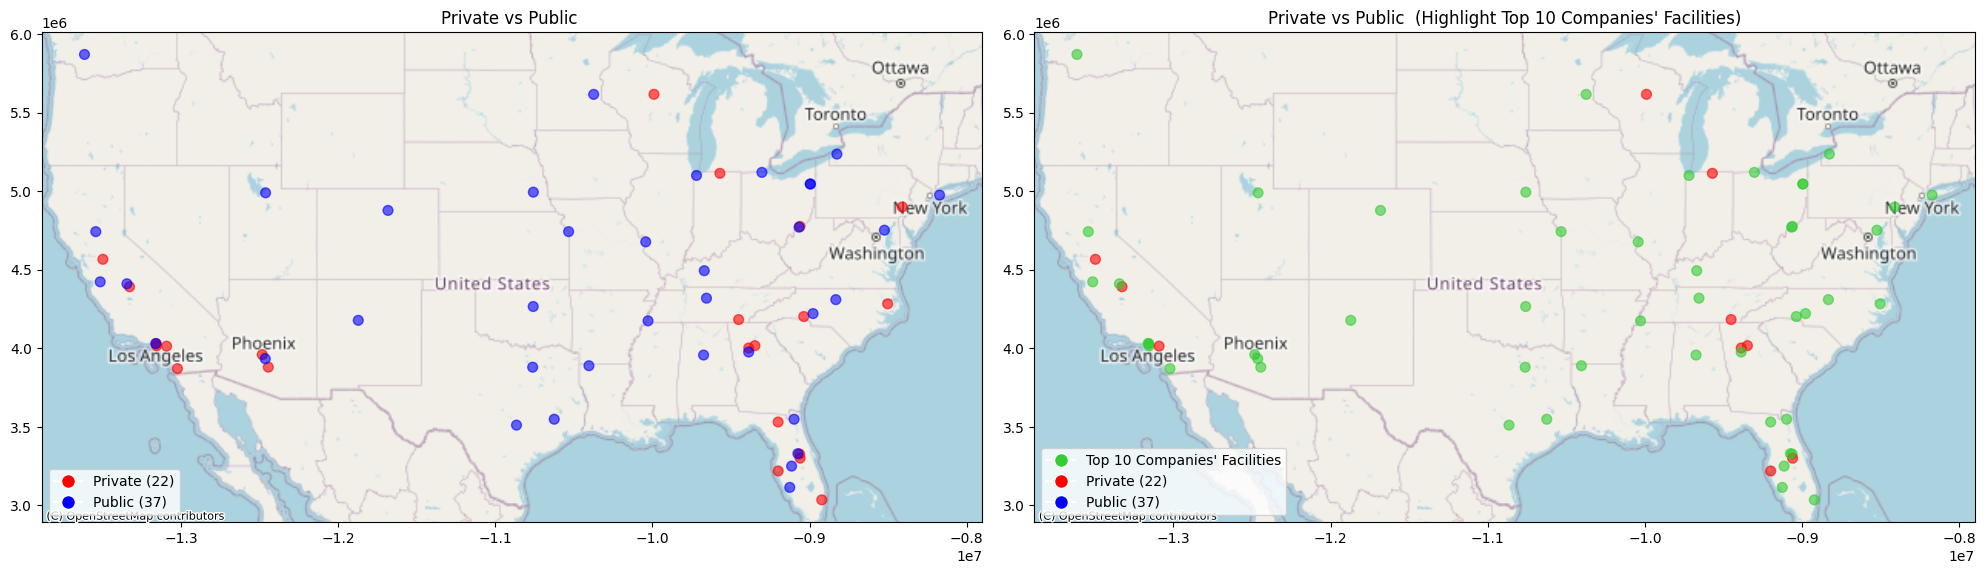

'Private_vs_Public__side_by_side.png'

In [16]:
generate_google_style_static_map(merged_df, ref_col='status', label_1='Private', label_2='Public', top_companies=top_companies)

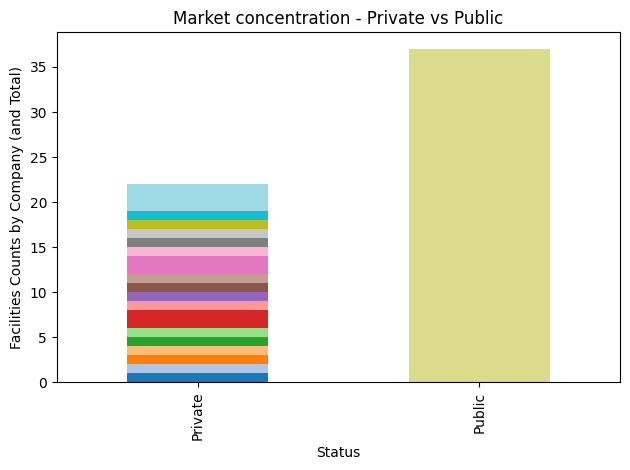

In [17]:
facilities_distribution = merged_df.groupby(['name', 'status']).size().sort_values(ascending=False).reset_index(name='count')
df_grouped = facilities_distribution.groupby(['status', 'name'])['count'].sum().unstack()

df_grouped.plot(kind='bar', stacked=True, colormap='tab20', legend=False)
plt.xlabel('Status')
plt.ylabel('Facilities Counts by Company (and Total)')
plt.xticks(rotation=90)
plt.title('Market concentration - Private vs Public')
plt.tight_layout()
plt.savefig('Market_concentration_private_vs_public.png')
plt.show()

In [18]:
merged_df_sorted = merged_df.sort_values(by='stateCode', ascending=False)
merged_df.to_csv('all_company_facilities_sorted_by_state.csv', index=False)